In [4]:
import pandas as pd
import numpy as np

import scipy as sp
import sklearn as sk
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p

import random
import time

import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

In [5]:
#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#set visual parameters
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 14,7

In [6]:
#common model algorithms
#common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import estimator
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import AdaBoostClassifier

#common model help tools
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [7]:
#import data
PATH1 = "C:/Users/kpunyakoti/Desktop/Data Science/Projects/AmEx Hack/Source/"   #where you read the files from
PATH2 = "C:/Users/kpunyakoti/Desktop/Data Science/Projects/AmEx Hack/Submissions/"   #where you export the files to

train = pd.read_csv(f'{PATH1}train.csv')
test = pd.read_csv(f'{PATH1}test.csv')
#Save the 'Id' column
train_ID = train['session_id']
test_ID = test['session_id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("session_id", axis = 1, inplace = True)
test.drop("session_id", axis = 1, inplace = True)

In [384]:
#concatenate train data and test data
ntrain = train.shape[0]
ntest = test.shape[0]

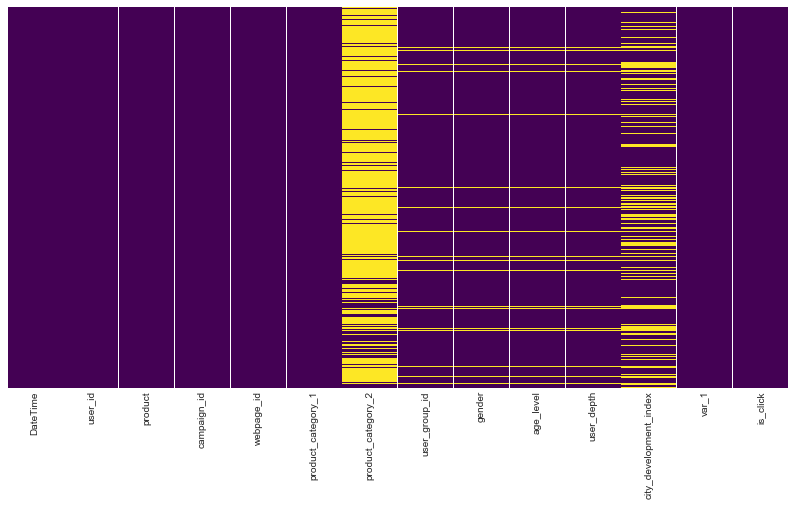

In [8]:
sns.heatmap(train.isnull(),cbar=False,yticklabels=False,cmap='viridis')

Target Variable
--

Treating outliers 
-- 
[always treat outliers first before treaing nulls]

CONCATENATE DATA

In [385]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.is_click.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['is_click'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (592149, 13)


In [386]:
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
all_data['Hour'] = all_data['DateTime'].dt.hour
all_data['Date'] = all_data['DateTime'].dt.day
all_data['Day'] = all_data['DateTime'].dt.weekday

Handling Missing Data
--

In [387]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
product_category_2,74.647597
city_development_index,26.975981
user_group_id,4.040706
user_depth,4.040706
gender,4.040706
age_level,4.040706


Text(0.5,1,'Percent missing data by feature')

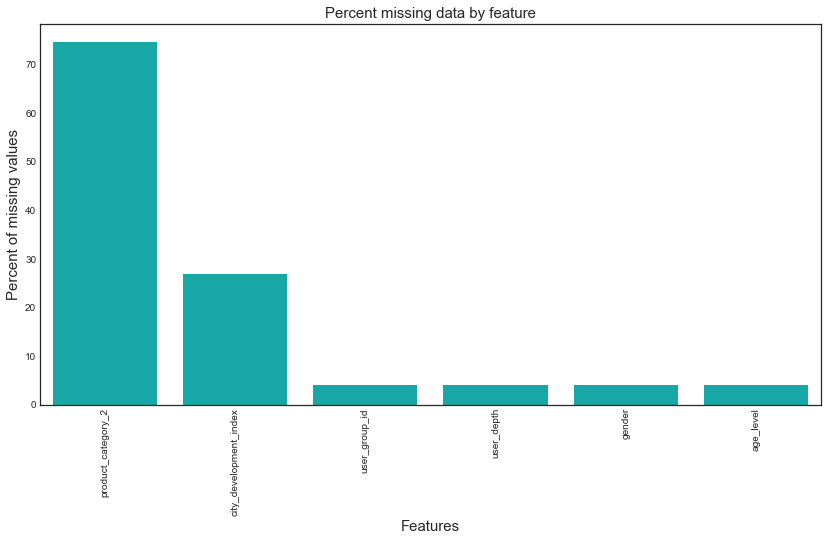

In [282]:
#plot missing data
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na, color="c")
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [388]:
#for user_depth - fill mode which is 3
all_data['user_depth'].fillna(3, inplace = True)
#for gender fill mode -first fill female
#all_data.loc[((all_data.product == 'B')|(all_data.product == 'F') & all_data['gender'].isnull()==True), 'gender'] = 'Female'
#then rest nas with mode - male
all_data['gender'].fillna(all_data['gender'].mode()[0], inplace = True)
#for age_group_id
all_data['user_group_id'].fillna(all_data['user_group_id'].median(), inplace = True)
#for age_level
all_data['age_level'].fillna(3, inplace = True)
#for city dev index
all_data['city_development_index'].fillna(all_data['city_development_index'].median(), inplace=True)

Drop Features
--

In [389]:
drop_cols = ['product_category_2', 'DateTime', 'user_id']   #
all_data.drop(drop_cols, axis=1, inplace=True)

In [390]:
#verify missing data
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


Convert Datatypes
--

In [297]:
cat_cols = ['webpage_id','campaign_id', 'age_level', 'user_depth']
for x in cat_cols:
    all_data[x] = all_data[x].astype('str')
    

Feature Engineering
--

In [412]:
all_data['Hzone'] = all_data['Hour']
all_data.Hzone.dtype

dtype('int64')

In [413]:
T1 = [23,0,1,2,3]
T2 = [22,4,5,6]
T3 = [7,8,9,10,11,12,13,14]
T4 = [15,16,17]
T5 = [18,19,20,21]

for a in T1:
    #a = str(a)
    all_data.loc[(all_data['Hzone']==a), 'Hzone'] = 1  
for a in T2:
    #a = str(a)
    all_data.loc[(all_data['Hzone']==a), 'Hzone'] = 2
for a in T3:
    #a = str(a)
    all_data.loc[(all_data['Hzone']==a), 'Hzone'] = 3    
for a in T4:
    #a = str(a)
    all_data.loc[(all_data['Hzone']==a), 'Hzone'] = 4
for a in T5:
    #a = str(a)
    all_data.loc[(all_data['Hzone']==a), 'Hzone'] = 5
all_data.Hzone.value_counts()

3    270961
5    143418
4     83183
2     74816
1     19771
Name: Hzone, dtype: int64

In [407]:
all_data['Dzone'] = all_data['Date']
all_data.Dzone.dtype

dtype('int64')

In [408]:
D1 = [2,3]
D2 = [4,5]
D3 = [6,7]
D4 = [8,9]

for d in D1:
    all_data.loc[(all_data['Dzone']==d), 'Dzone'] = '8'  
for d in D2:
    all_data.loc[(all_data['Dzone']==d), 'Dzone'] = '6'
for d in D3:
    all_data.loc[(all_data['Dzone']==d), 'Dzone'] = '4'    
for d in D4:
    all_data.loc[(all_data['Dzone']==d), 'Dzone'] = '2'
all_data.Dzone.value_counts()

8    160425
6    153874
4    148992
2    128858
Name: Dzone, dtype: int64

In [398]:
cols = ['webpage_id', 'campaign_id','user_group_id', 'user_depth' , 'gender', 'product', 'age_level', 'Hzone', 'Dzone']
# Process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values)) 

In [414]:
#retrieve cleaned data to separate train/test sets for Machine Learning
train = all_data[:ntrain]
test = all_data[ntrain:]
all_data.head()

,age_level,campaign_id,city_development_index,gender,product,product_category_1,user_depth,user_group_id,var_1,webpage_id,Hour,Date,Day,Tzone,Dzone,Hzone
0,4,4,3.0,0,2,4,2,10,0,3,0,2,6,1,8,1
1,2,2,2.0,0,2,5,1,8,0,2,0,2,6,1,8,1
2,2,4,2.0,0,2,4,1,8,0,3,0,2,6,1,8,1
3,3,4,2.0,1,8,3,2,3,1,3,0,2,6,1,8,1
4,2,8,2.0,1,2,3,2,2,1,8,0,2,6,1,8,1


In [476]:
print(train.shape)
print(test.shape)

(463291, 16)
(128858, 16)


In [477]:
train.to_csv(f'{PATH2}train_data_cleaned.csv', index=False)
test.to_csv(f'{PATH2}test_data_cleaned.csv', index=False)

In [467]:
imp_feat = ['Hzone','webpage_id', 'product','gender', 'user_group_id', 'Dzone', 'var_1']
new_train = train[imp_feat]
new_test = test[imp_feat]

In [468]:
dummy_col = ['Hzone','webpage_id', 'product','gender', 'user_group_id',  'var_1']
new_train= pd.get_dummies(new_train, columns= dummy_col)
new_test= pd.get_dummies(new_test, columns= dummy_col)

In [469]:
print(new_train.shape)
print(new_test.shape)
new_train.head()

(463291, 42)
(128858, 42)


,Dzone,Hzone_1,Hzone_2,Hzone_3,Hzone_4,Hzone_5,webpage_id_0,webpage_id_1,webpage_id_2,webpage_id_3,...,user_group_id_5,user_group_id_6,user_group_id_7,user_group_id_8,user_group_id_9,user_group_id_10,user_group_id_11,user_group_id_12,var_1_0,var_1_1
0,8,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,8,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,8,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,8,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,8,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


dtype('int64')

Machine Learning
--

Define a cross validation strategy

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [226]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))

    return(rmse)

In [470]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(new_train, 
                                                        y_train, train_size = 0.7, test_size = 0.3, random_state = 0)

Initializing Models
--

In [471]:
lr = linear_model.LogisticRegression(C= 0.7, class_weight= 'balanced' )
lr.fit(train_x, train_y)

lr_predict_probabilities = lr.predict_proba(test_x)[:,1]

lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_predict_probabilities)
lr_roc_auc = auc(lr_fpr, lr_tpr)

In [472]:
nb = GaussianNB()
nb.fit(train_x, train_y)

nb_predict_probabilities = nb.predict_proba(test_x)[:,1]

nb_fpr, nb_tpr, _ = roc_curve(test_y, nb_predict_probabilities)
nb_roc_auc = auc(nb_fpr, nb_tpr)

In [423]:
rf = ensemble.RandomForestClassifier(n_estimators = 150)
rf.fit(train_x, train_y)

rf_predict_probabilities = rf.predict_proba(test_x)[:,1]

rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_predict_probabilities)
rf_roc_auc = auc(rf_fpr, rf_tpr)

In [133]:
ada = AdaBoostClassifier()

ada.fit(train_x, train_y)

ada_predict_probabilities = ada.predict_proba(test_x)[:,1]

ada_fpr, ada_tpr, _ = roc_curve(test_y, ada_predict_probabilities)
ada_roc_auc = auc(ada_fpr, ada_tpr)

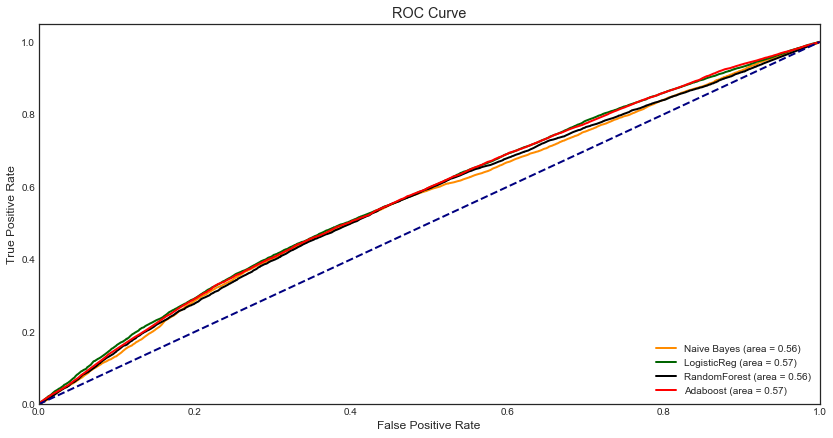

In [473]:
plt.figure()
plt.plot(nb_fpr, nb_tpr, color='darkorange',
         lw=2, label='Naive Bayes (area = %0.2f)' % nb_roc_auc)
plt.plot(lr_fpr, lr_tpr, color='darkgreen',
         lw=2, label='LogisticReg (area = %0.2f)' % lr_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=2, label='RandomForest (area = %0.2f)' % rf_roc_auc)
plt.plot(ada_fpr, ada_tpr, color='red',
         lw=2, label='Adaboost (area = %0.2f)' % ada_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [124]:
tr_y['clk'] = pd.DataFrame(train_y)
print('Train samples: \n',tr_y['clk'].value_counts())
tst_y['clk'] = pd.DataFrame(test_y)
print('\nTest samples: \n',tst_y['clk'].value_counts())

tr_x = pd.DataFrame(train_x)
tr_x['is_click'] = pd.DataFrame(train_y)
tst_x = pd.DataFrame(test_x)
tst_x['is_click'] = pd.DataFrame(test_y)

tr_x.to_csv(f'{PATH1}tr_x.csv', index=False)
tst_x.to_csv(f'{PATH1}tst_x.csv', index=False)


Train samples: 
 0    345560
1     25072
Name: clk, dtype: int64

Test samples: 
 0    86400
1     6259
Name: clk, dtype: int64


                                            ---------------------------
                                            ---- END OF PLAYGROUND ----
                                            ---------------------------

Tensorflow
--

In [227]:
score = rmsle_cv(lr)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.2601 (0.0000)



In [228]:
score = rmsle_cv(nb)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.4730 (0.0180)



In [229]:
score = rmsle_cv(rf)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.3992 (0.0975)



Final Training and Predictions
--

In [239]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.2540480844908348


In [241]:
nb.fit(train, y_train)
nb_train_pred = nb.predict(train)
nb_pred = np.expm1(nb.predict(test))
print(rmsle(y_train, nb_train_pred))

0.39796705873767535


In [202]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

In [474]:
#submit = pd.DataFrame()
#submit['Id'] = test.index
#submit['SalePrice'] = ensemble
preds = lr.predict(new_test)
submit = pd.DataFrame({'session_id': test_ID, 'is_click': preds})
submit.to_csv(f'{PATH2}submission_tst.csv', index=False)

In [475]:
prd['clck'] = pd.DataFrame(preds)
prd.clck.value_counts()

0    101944
1     26914
Name: clck, dtype: int64